In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
import time
import warnings
warnings.filterwarnings("ignore")

In [33]:
# Load in data, create train, validation split, get categorical variables when using SMOTENC
train = pd.read_csv('train_clean.csv', index_col=[0])
test = pd.read_csv('test_clean.csv', index_col=[0])
xf_train = train.loc[:,train.columns != 'Attrition_Yes']
yf_train = train.Attrition_Yes
x_train, x_val, y_train, y_val = train_test_split(train.loc[:,train.columns != 'Attrition_Yes'], train.Attrition_Yes, test_size = 0.2)

x_cat = [x_train.columns.get_loc(c) for c in x_train.columns if '_' in c]

In [34]:
smote = SMOTENC(categorical_features=x_cat)
xf_sr_train, yf_sr_train = smote.fit_resample(x_train, y_train)

In [35]:
# Conduct 5-fold cross validation on n_estimators, learning_rate parameters, store result
n_estimators = [10, 20, 50, 100, 200]
learning_rates = [0.1, 0.25, 0.5, 1, 1.5, 2]

kfold = KFold(n_splits=5)
n_est_train_scores = []
n_est_val_scores = []
for n in n_estimators:
    lr_train_scores = []
    lr_val_scores = []
    for lr in learning_rates:
        train_scores = []
        val_scores = []
        for tr_idx, val_idx in kfold.split(xf_train):
            xt_up, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=15).fit_resample(xf_train.iloc[tr_idx], yf_train.iloc[tr_idx])
            ab_model = AdaBoostClassifier(n_estimators=n, learning_rate=lr).fit(xt_up, yt_up)
            # print(f1_score(ab_model.predict(xf_train.iloc[val_idx]), yf_train.iloc[val_idx]))
            train_scores.append(f1_score(ab_model.predict(xf_train.iloc[tr_idx]), yf_train.iloc[tr_idx]))
            val_scores.append(f1_score(ab_model.predict(xf_train.iloc[val_idx]), yf_train.iloc[val_idx]))
        lr_train_scores.append(np.mean(train_scores))
        lr_val_scores.append(np.mean(val_scores))
    n_est_train_scores.append(lr_train_scores)
    n_est_val_scores.append(lr_val_scores)

Text(0.5, 1.0, 'AdaBoost Cross Validation Validation Fold F1 Scores')

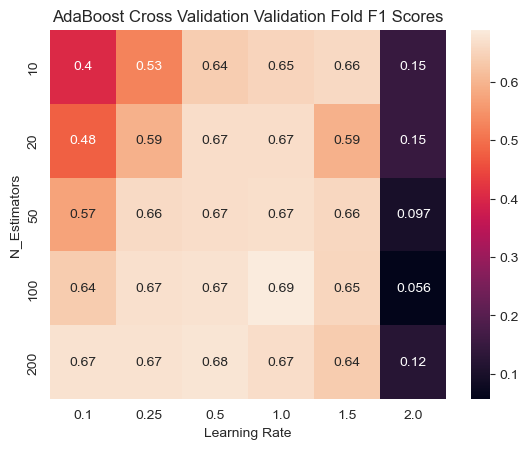

In [36]:
# Visualize validation f1 scores from cross validation
ab_train_scores = pd.DataFrame(n_est_train_scores)
ab_val_scores = pd.DataFrame(n_est_val_scores)

ab_val_scores.columns = learning_rates
ab_val_scores.index = n_estimators

ab_train_scores.columns = learning_rates
ab_train_scores.index = n_estimators

sns.heatmap(ab_val_scores, annot=True)
plt.ylabel('N_Estimators')
plt.xlabel('Learning Rate')
plt.title('AdaBoost Cross Validation Validation Fold F1 Scores')
# plt.savefig('Graphs/ABCVVal.png', bbox_inches='tight')

Text(0.5, 1.0, 'AdaBoost Cross Validation Train Fold F1 Scores')

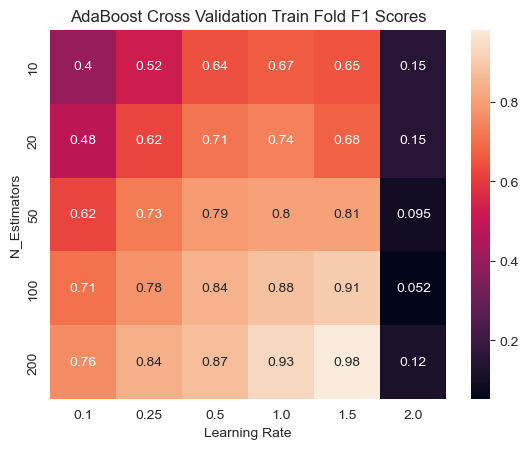

In [37]:
# Visualize train f1 scores from cross validation
sns.heatmap(ab_train_scores,annot=True)
plt.ylabel('N_Estimators')
plt.xlabel('Learning Rate')
plt.title('AdaBoost Cross Validation Train Fold F1 Scores')
# plt.savefig('Graphs/ABCVTrain.png', bbox_inches='tight')

0.16730332374572754


Text(0.5, 0, 'Feature Importance')

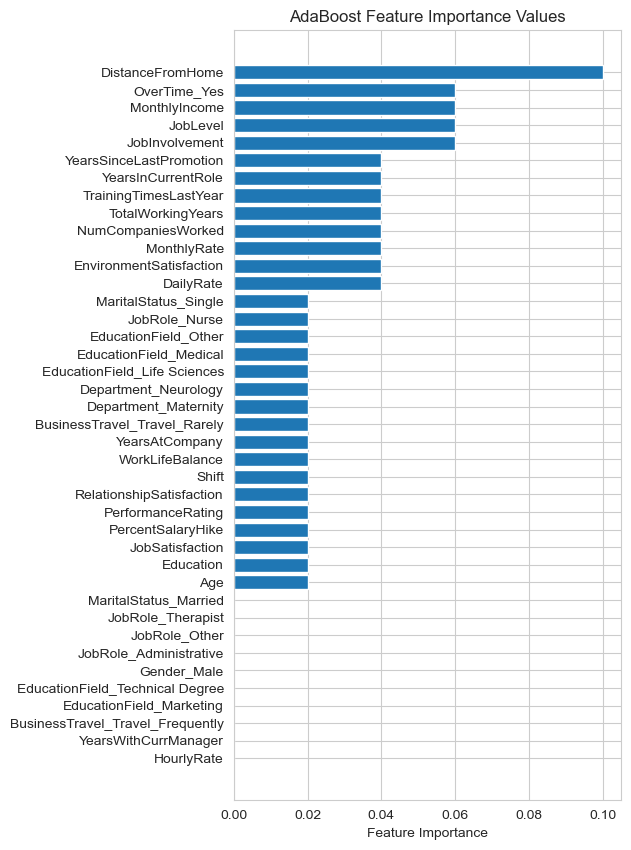

In [38]:
# Make bar chart of feature importance values
smote = SMOTENC(categorical_features=x_cat, k_neighbors=8)
x_sr_train, y_sr_train = smote.fit_resample(xf_train, yf_train)
cur = time.time()
cv_ab = AdaBoostClassifier(n_estimators=50, learning_rate=1).fit(x_sr_train, y_sr_train)
print(time.time() - cur)
plt.figure(figsize=(5,10))
f_i = list(zip(x_sr_train.columns, cv_ab.feature_importances_))
f_i.sort(key=lambda x: x[1], reverse=False)
s_c = [x[0] for x in f_i]
s_f = [x[1] for x in f_i]
plt.barh(s_c, s_f)
plt.title('AdaBoost Feature Importance Values')
plt.xlabel('Feature Importance')
# plt.savefig('Graphs/ABFI.png', bbox_inches='tight')

Train f1:  0.9687665431445209
Val f1:  0.696969696969697


Text(52.722222222222214, 0.5, 'True Attrition Value')

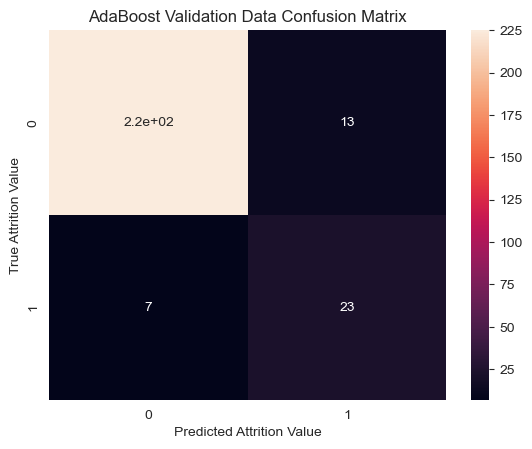

In [39]:
# Generate confusion matrix on validation data
smote = SMOTENC(categorical_features=x_cat, k_neighbors=5)
xsr_train, ysr_train = smote.fit_resample(x_train, y_train)
ab_cv_model = AdaBoostClassifier(n_estimators=50, learning_rate=1).fit(xsr_train, ysr_train)
print('Train f1: ', f1_score(ab_cv_model.predict(xsr_train), ysr_train))
print('Val f1: ', f1_score(ab_cv_model.predict(x_val), y_val))
sns.heatmap(confusion_matrix(y_pred=ab_cv_model.predict(x_val), y_true=y_val), annot=True)
plt.title('AdaBoost Validation Data Confusion Matrix')
plt.xlabel('Predicted Attrition Value')
plt.ylabel('True Attrition Value')
# plt.savefig('Graphs/ABCM.png', bbox_inches='tight')

In [40]:
# Generate submissions using best model as determined through cross validation
smote = SMOTENC(categorical_features=x_cat, k_neighbors=10)
xf_sr_train, yf_sr_train = smote.fit_resample(xf_train, yf_train)
ab_predictions_model = AdaBoostClassifier(n_estimators=50, learning_rate=1).fit(xf_sr_train, yf_sr_train)
submission18 = pd.DataFrame(ab_predictions_model.predict(test)).rename(columns={0: 'Predicted'})
submission18.index.rename('Id', inplace=True)
submission18.to_csv('submission18.csv')